# UBI as a means of reducing gendered poverty

This year's International Women's Day asks its celebrants to challenge the world in order to change it (#ChooseToChallenge). The following simulation seeks to challenge the fact that women in the United States are more likely to be impoverished than men. In our analysis, we evaluate a Universal Basic Income (UBI), funded by a flat income tax, as a possible solution for both alleviating poverty and narrowing the gendered poverty gap.

Modeling notes: Data was gathered from the US Census Bureau’s March Supplement, which covers economic circumstances in 2019. We use the Supplemental Poverty Measure, which incorporates taxes and transfers (including in-kind benefits like SNAP) and adjusts for local housing costs. The flat income tax is applied on positive adjusted gross income.

Poverty rates for children are roughly equal between genders, while adult women experience poverty at rates 17% greater than adult men: 12.4% vs. 10.6%. As a general trend, the difference in poverty rates between women and men increases with age. For example, 20.8% of women aged 85 or older are in poverty, compared to only 14.5% of men of the same age. Among people aged 85 or older, women experience deep poverty at twice the rate of men.

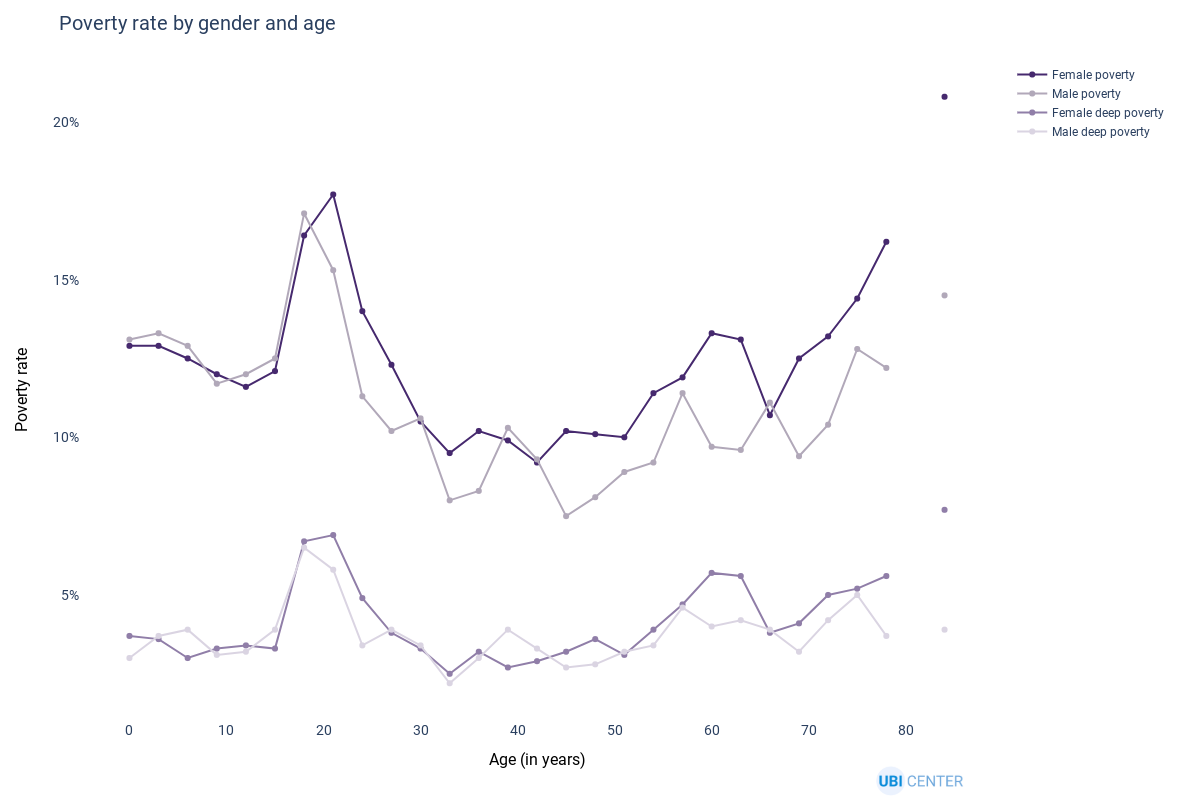

In [33]:
import microdf as mdf
import numpy as np
import pandas as pd
import plotly.express as px
import ubicenter

df = pd.read_csv(
    "https://github.com/MaxGhenis/datarepo/raw/master/pppub20.csv.gz",
    usecols=[
        "MARSUPWT",
        "SPM_RESOURCES",
        "SPM_POVTHRESHOLD",
        "SPM_WEIGHT",
        "SPM_NUMPER",
        "A_SEX",
        "A_AGE",
        "SPM_ID",
        "AGI",
    ],
)
df.columns = df.columns.str.lower()
df["weight"] = df.marsupwt / 100
df["spm_weight"] = df.spm_weight / 100
df["female"] = df.a_sex == 2
df["poverty"] = df.spm_resources < df.spm_povthreshold
df["deep_poverty"] = df.spm_resources < (df.spm_povthreshold / 2)
df["sex"] = np.where(df.female, "Female", "Male")

spm = df.groupby(
    ["spm_id", "spm_resources", "spm_weight", "spm_povthreshold", "spm_numper"]
)[["agi"]].sum()
spm["agi_pos"] = np.maximum(spm.agi, 0)
spm.reset_index(inplace=True)

total_population = df.weight.sum()
total_agi_pos = mdf.weighted_sum(spm, "agi_pos", "spm_weight")

# Bin into ages aligning with 18 year old threshold.
LIGHT_PURPLE = "#907EA8"
DARK_PURPLE = "#46296E"
LIGHT_GREY = "#DAD4E2"
DARK_GREY = "#B1A8B9"

COLOR_MAP = {
    "Female": DARK_PURPLE,
    "Male": LIGHT_GREY,
    "Female poverty": DARK_PURPLE,
    "Female deep poverty": LIGHT_PURPLE,
    "Male poverty": DARK_GREY,
    "Male deep poverty": LIGHT_GREY,
}

df["age_group"] = pd.cut(df.a_age, np.arange(0, 88, 3), labels=np.arange(0, 85, 3))
pov_age = mdf.weighted_mean(
    df, ["poverty", "deep_poverty"], "marsupwt", groupby=["age_group", "sex"]
)
pov_age = 100 * pov_age.round(3)
pov_age.reset_index(inplace=True)
pov_age = pov_age.melt(["age_group", "sex"], ["poverty", "deep_poverty"])
pov_age["label"] = (
    pov_age.sex
    + " "
    + np.where(pov_age.variable == "poverty", "poverty", "deep poverty")
)

fig = px.line(
    pov_age, x="age_group", y="value", color="label", color_discrete_map=COLOR_MAP
)
fig.update_layout(
    title="Poverty by gender and age",
    xaxis_title="Age (in years)",
    yaxis_title="Poverty rate",
    legend_title="",
    yaxis_ticksuffix="%",
)

fig.update_traces(mode="markers+lines", hovertemplate=None)

ubicenter.format_fig(fig)

<AxesSubplot:xlabel='age_group'>

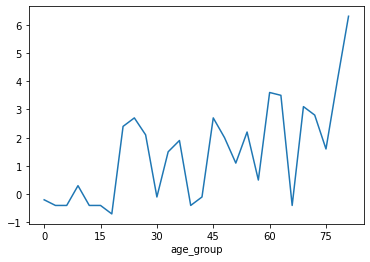

In [34]:
pov_age_diff = pov_age[pov_age.variable == "poverty"].pivot_table(
    values="value", index="age_group", columns="sex"
)
pov_age_diff["female_minus_male"] = pov_age_diff.Female - pov_age_diff.Male
pov_age_diff.female_minus_male.plot()

With a significant difference in rates of poverty for adult women as compared to men, how might a UBI help close that gap? Our past modeling has shown that a UBI would lessen poverty across demographic groups, and also shrink poverty disparities by race (https://blog.ubicenter.org/20210118/racial-poverty-disparities-mlk-day-2021.html), Indigenous heritage (https://blog.ubicenter.org/20201012/indigenous.html), and disability status (https://blog.ubicenter.org/20200731/ada30.html). Our research here shows that it would do the same by gender.

After receiving a UBI, the poverty rates for women and men converge as the monthly amount increases (we've focused on adults here). Consistent with our past simulations, a \$300 monthly UBI would halve the rate of female poverty and female deep poverty.

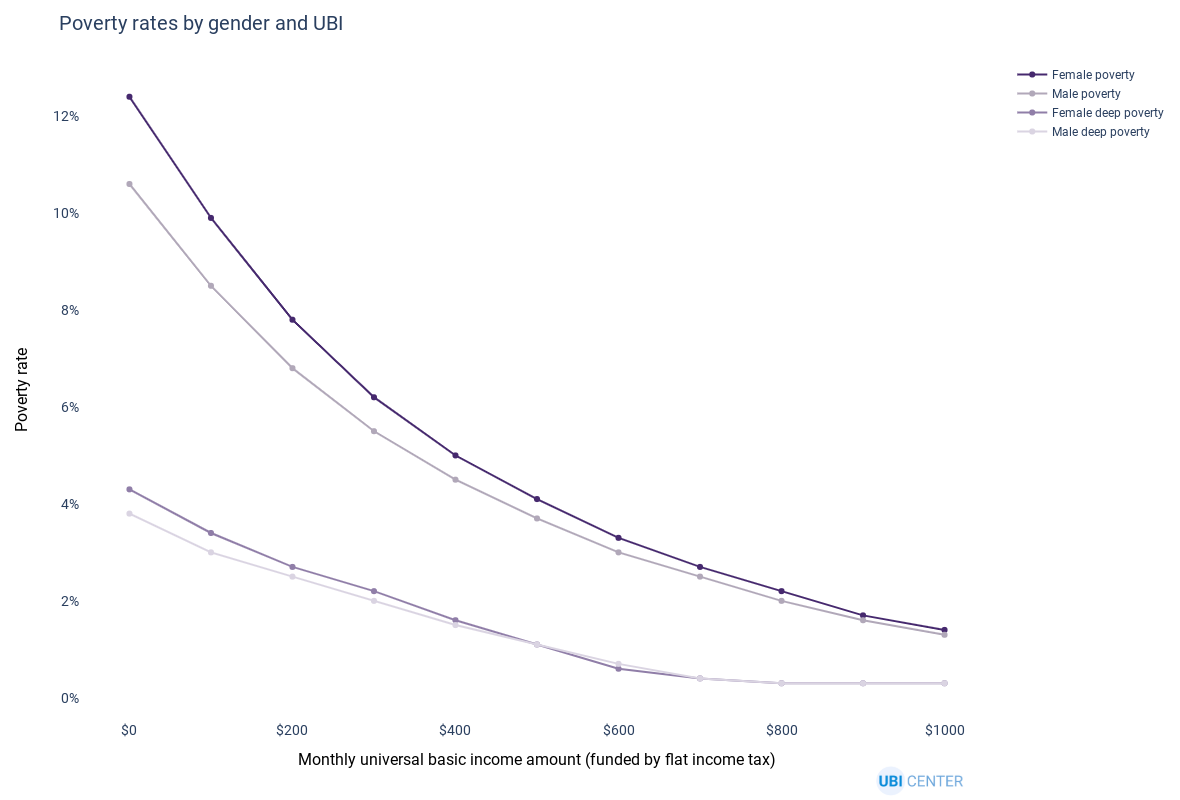

In [35]:
def pov(female, monthly_ubi):
    # Calculate poverty rates for a gender subset given a monthly UBI amount.
    cost = monthly_ubi * total_population * 12
    tax_rate = cost / total_agi_pos  # Divide by positive AGI.
    spm["new_resources"] = (
        spm.spm_resources - tax_rate * spm.agi_pos + (12 * monthly_ubi * spm.spm_numper)
    )
    person = df[(df.female == female) & (df.a_age > 17)].merge(
        spm[["spm_id", "new_resources"]], on="spm_id"
    )
    return pd.Series(
        dict(
            pov=mdf.poverty_rate(
                person, income="new_resources", threshold="spm_povthreshold", w="weight"
            ),
            deep_pov=mdf.deep_poverty_rate(
                person, income="new_resources", threshold="spm_povthreshold", w="weight"
            ),
        )
    )


def pov_row(row):
    return pov(row.female, row.monthly_ubi)


gender_ubi = mdf.cartesian_product(
    {"female": [True, False], "monthly_ubi": np.arange(0, 1001, 100)}
)
gender_ubi = pd.concat([gender_ubi, gender_ubi.apply(pov_row, axis=1)], axis=1)

gender_ubi_long = gender_ubi.melt(
    id_vars=["female", "monthly_ubi"], value_vars=["pov", "deep_pov"]
)
gender_ubi_long["label"] = (
    pd.Series(np.where(gender_ubi_long.female, "Female", "Male"))
    + " "
    + pd.Series(np.where(gender_ubi_long.variable == "pov", "poverty", "deep poverty"))
)
gender_ubi_long.value = 100 * gender_ubi_long.value.round(3)

fig = px.line(
    gender_ubi_long,
    x="monthly_ubi",
    y="value",
    color="label",
    color_discrete_map=COLOR_MAP,
)

fig.update_layout(
    title="Poverty by gender and UBI amount",
    xaxis_title="Monthly universal basic income amount (funded by flat income tax)",
    xaxis_tickprefix="$",
    yaxis_title="Poverty rate",
    legend_title="",
    yaxis_ticksuffix="%",
)

fig.update_traces(mode="markers+lines", hovertemplate=None)
ubicenter.format_fig(fig)

In our modeling, a monthly UBI significantly narrows the ratio of poverty and deep poverty rates for adult women compared to adult men. With a monthly UBI of \$500, the rate of women compared to men in poverty is more than halved and the rate of women compared to men in deep poverty is nearly equal. 

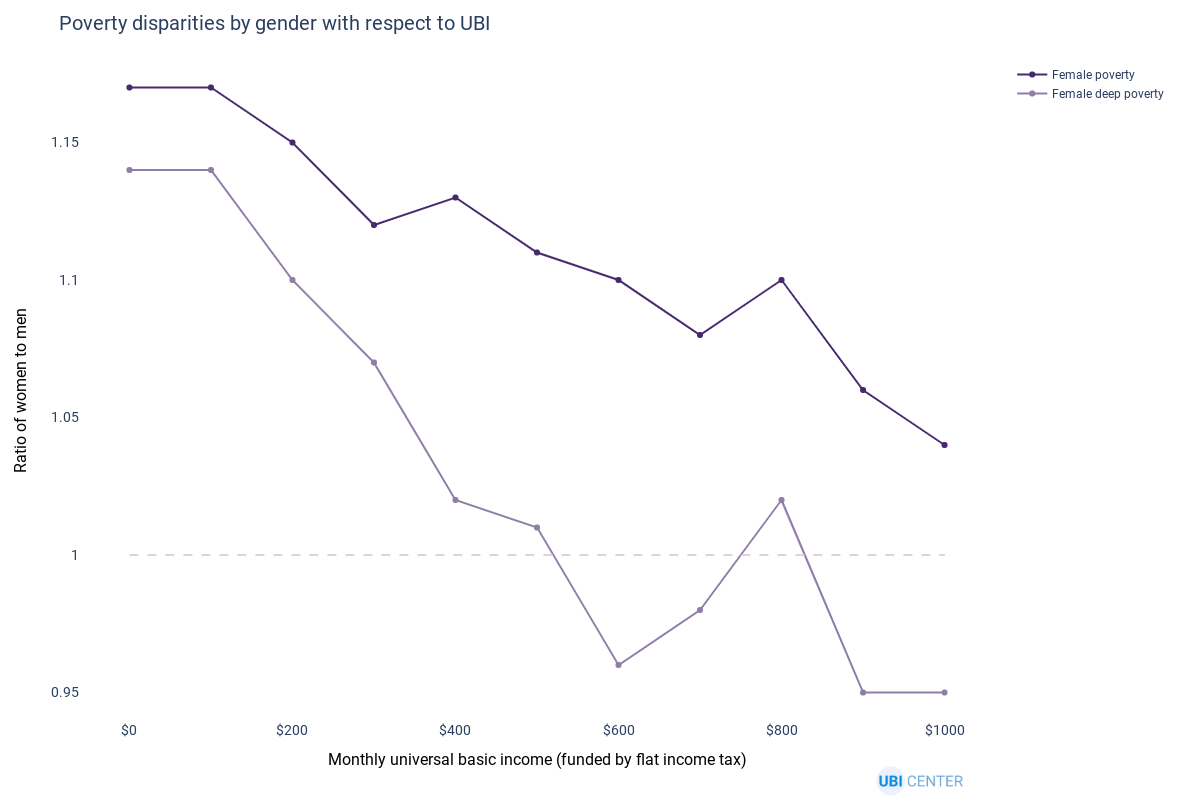

In [36]:
gender_ratio = gender_ubi.pivot_table(
    values="pov", index=["monthly_ubi"], columns="female"
).reset_index()
gender_ratio.rename({True: "female", False: "male"}, axis=1, inplace=True)
gender_ratio["ratio"] = gender_ratio.female / gender_ratio.male
gender_ratio["poverty_type"] = "Female poverty"
deep_gender_ratio = gender_ubi.pivot_table(
    values="deep_pov", index=["monthly_ubi"], columns="female"
).reset_index()
deep_gender_ratio.rename({True: "female", False: "male"}, axis=1, inplace=True)
deep_gender_ratio["ratio"] = deep_gender_ratio.female / deep_gender_ratio.male
deep_gender_ratio["poverty_type"] = "Female deep poverty"

gender_ratios = pd.concat([gender_ratio, deep_gender_ratio])
gender_ratios.ratio = gender_ratios.ratio.round(2)

fig = px.line(
    gender_ratios,
    x="monthly_ubi",
    y="ratio",
    color="poverty_type",
    color_discrete_map=COLOR_MAP,
)

fig.update_yaxes(range=[0.94, 1.18])
fig.add_shape(
    type="line",
    x0=0,
    y0=1,
    x1=1000,
    y1=1,
    line=dict(color=LIGHT_GREY, dash="dash"),
    xref="x",
    yref="y",
)

fig.update_layout(
    title="Poverty disparities by gender with respect to UBI",
    xaxis_title="Monthly universal basic income (funded by flat income tax)",
    xaxis_tickprefix="$",
    yaxis_title="Ratio of women to men",
    legend_title="",
)

fig.update_traces(mode="markers+lines", hovertemplate=None)
ubicenter.format_fig(fig)

The question remains why women are more likely to be in poverty than men. Recent research suggests that a “baby penalty” may be at fault, though it is difficult to say with certainty whether that fully explains the gap.  

The gender income gap is inseparable from the issue of care work. On one hand, the "baby penalty"(https://www.vox.com/2018/2/19/17018380/gender-wage-gap-childcare-penalty) explains much of the gap, with mothers earning less than fathers while women and men without children have similar earnings. Meanwhile, high marginal tax rates (https://aspe.hhs.gov/system/files/aspe-files/260661/brief2-overviewmtranalyses.pdf) for low-income parents (due to the phasing out of benefits) discourages work disproportionately of mothers. A recent poll (https://americancompass.org/essays/home-building-survey-part-2/) found that Americans prefer cash assistance to other family assistance policies like paid family leave, subsidized childcare, wage subsidies, and baby bonds. Mothers, fathers, and low-income people especially preferred cash assistance, which would likely be more distributionally progressive than other policy options. 

In her paper advocating for UBI as compared to other alternatives, political scientist Almaz Zelleke states that:

“Perhaps most importantly for advocates of gender equality, a basic income by virtue of its universality goes to both providers and recipients of care, and thus has the best chance of eliminating poverty for the most vulnerable group in contemporary capitalist economies: single mothers and their children. To any feminist, this should be a strong argument in favor of basic income.” -- Zelleke (https://almazzelleke.files.wordpress.com/2014/01/zelleke-institutionalizing-the-universal-caretaker-dec-2008.pdf)

Women provide most of the care work that today goes unpaid and unrecognized. UBI compensates for that care work, reducing gender inequities and investing in the well-being of the cared-for. Our analysis suggests that a UBI could be a relevant policy in the greater movement for the social, economic, and political equality of women. 